# CS 410 Final Project:  Aspect Based Sentiment Analysis

## Cristian Jansenson
## Peter Tsapatsaris

The application contained in this notebook performs two tasks:  (1) parses customer reviews into specified aspects (e.g., "screen", "camera", "value"), such that phrases are extracted that are assocaited with the relevant aspect; and (2) assigns sentiment ratings to each aspect, generating a set of sentiment scores for each product.

To demonstrate the software, we will be loading and processing over 400k Amazon reviews of unlocked phones.  In the processing section of the algorithm, we will extract a fixed set of aspects/features about these reviews.  We will then perform sentiment analysis on them, with the goal of understanding if these reviews reflect positively or negatively on each of these aspects. The results will show that even a basic implementation ABSA can be powerful and useful. 

We obtained the data from https://www.kaggle.com/nehasontakke/amazon-unlocked-mobilecsv.  

### Load libraries and data 
To use this application, customer reviews should be contained in a CSV file with the following columns, "Product Name", "Brand Name", "Price", "Rating", "Reviews", "Review Votes".  Other data formats will require some changes to the code.

In [1]:
import pandas as pd
import numpy as np

# The product names are not standard, so we'll group by brand name
reviewsDF = pd.read_csv('Amazon_Unlocked_Mobile.csv')
# normalize brand names
reviewsDF['Brand Name'] = reviewsDF['Brand Name'].str.lower()
reviews = reviewsDF.Reviews.tolist()
brands = reviewsDF['Brand Name'].tolist()
ratings = reviewsDF['Rating'].tolist()
print("Loaded " + str(len(reviews)) + " reviews.")

Loaded 413840 reviews.


In [2]:
reviewsDF.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


## Part 1:  Segment customer reviews into aspect associated phrases

We want to transform this reviews dataframe into a phrases dataframe, with phrase being a sequence of words containing one of the aspect terms.

#### The aspects
For this exercise, we handpicked the following aspects: "battery", "screen", "camera", and  "performance". These aspects can be easily changed by editing the relevant_aspects variable below.  

#### About the new dataframe
The new dataframe will contain phrases with the aspects we find relevant, along with the review ID for each phrase. To find the phrases in the review, first we break down the review into sentences.  Within each sentence, we are looking and extracting the aspect and the surrounding words. For example, consider the following review:

```
Had the phone for less than a week and it died; no warning. I found that the screen is great because it is bright even in the sunlight. 3g on ATT is fast.Doesn't matter about the features though. Dying in a few days is a sure way to get 1 
star.
```

In this review the aspect term **screen** is found in the sentence "I found that the screen is great because it is bright even in the sunlight."To obtain a phrase containing the aspect 'screen' we extract the aspect and the 5 neighboring terms to the right and left of this aspect. To be considered a neighboring term, it must be at least 3 characters long.  In this case, the following phrase is extracted: "found that screen great because bright even sunlight"

![alt text](fromDFtoDF1.jpg "Title")

#### Helper function:   get_all_phrases_containing_tar_wrd

Given a review, this function returns all the neighborhood terms containing the target word in a text/passage.

In [10]:
# Reference: https://simply-python.com/2014/03/14/saving-output-of-nltk-text-concordance/  

import nltk
def get_all_phrases_containing_tar_wrd(target_word, tar_passage, left_margin = 5, right_margin = 5):
    """
        Function to get all the pharses that contain the target word in a text/passage tar_passage.
        Workaround to save the output given by nltk Concordance function
        
        str target_word --> aspect to be searched for
        str tar_passage  --> sentence extracted from a customer review
        int left_margin int right_margin --> left_margin and right_margin allocate the number of words/punctuation before and after target word
        Left margin will take note of the beginning of the text
    """
     
    ## Create list of tokens using nltk function
    tokens = nltk.word_tokenize(tar_passage)
    tokens = [x for x in tokens if len(x)>2] 
    ## Create the text of tokens
    text = nltk.Text(tokens)
 
    ## Collect all the index or offset position of the target word
    c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())
 
    ## Collect the range of the words that is within the target word by using text.tokens[start;end].
    ## The map function is use so that when the offset position - the target range < 0, it will be default to zero
    
    concordance_txt = ([text.tokens[  list(map(lambda x: x-5 if (x-left_margin)>0 else 0,[offset]))[0]:offset+right_margin] for offset in c.offsets(target_word)])

    ## join the sentences for each of the target phrase and return it
    return [''.join([x+' ' for x in con_sub]) for con_sub in concordance_txt]

#### Breaking down the sentences into phrases containing relevant aspects.

Below is the main body of the aspect extraction code.  The pseudocode is as follows:
```
For each review in the list of reviews:
    Break down the review in sentences.
    for each sentence in the review:
        Break down the sentence into phrases - a phrase here is a +/- 5 words neighborhood of the aspect.
        For each phrase containing a relevant aspect:
            Append data for a new row entry for the dataframe.
```

In [11]:
from nltk import sent_tokenize

## Select the aspects we believe are relevant 
relevant_aspects = ['battery', 'screen', 'camera', 'performance']

## Make lists for each of the columns that we will have in our new dataframe
phrases = []
brand = []
rating = []
aspects = []
review_num = []
counter = 0
# Loop through all the reviews
for review in reviews:
    try:
        # Break the reviews in sentences and loop through them
        for sentence in sent_tokenize(review):
            for  important_word in relevant_aspects:
                # Get all the phrases containing one of the topic names
                # Create append list of phrases, aspects, ratings etc to create a DF
                phrases_in_sentence = get_all_phrases_containing_tar_wrd(important_word, sentence, left_margin = 5, right_margin = 5) 
                for phrase in phrases_in_sentence:
                    brand.append(brands[counter])
                    rating.append(ratings[counter])
                    aspect = 'other'
                    for imp_word in relevant_aspects:
                        if imp_word in phrase.lower():
                            aspect = imp_word
                    aspects.append(aspect)
                    phrases.append(phrase)
                    review_num.append(counter)
    except:
        pass
    counter = counter + 1

print('Extracted ' + str(len(phrases)) + ' phrases from the reviews')

# Create the phrases dataframe
phrasesDF = pd.DataFrame()
phrasesDF['brand'] = brand 
phrasesDF['phrase'] = phrases
phrasesDF['rating'] = rating
phrasesDF['aspect'] = aspects
phrasesDF['review_id'] = review_num
phrasesDF.head()


Extracted 155302 phrases from the reviews


,brand,phrase,rating,aspect,review_id
0,samsung,Then needed new battery well,2,battery,6
1,samsung,stay charged had buy new battery,2,battery,7
2,samsung,But the camera works great the video,5,camera,8
3,samsung,also notice that battery life lasts little bit,5,battery,8
4,samsung,battery life great,3,battery,9


## Part 2:  Perform sentiment analysis on each aspect phrase

We us the vader sentiment analyzer from the NLTK library to perform sentiment analysis on each phrase, and we append the reults to the dataframe. 

In [12]:
# https://opensourceforu.com/2016/12/analysing-sentiments-nltk/
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
vader_sentiment = []  
vader_sentiment_neg = [] 
vader_sentiment_pos = []
sid = SentimentIntensityAnalyzer()
for sentence in phrasesDF['phrase']:
    try:
        vader_sentiment.append(sid.polarity_scores(sentence)['compound'])
        vader_sentiment_pos.append(sid.polarity_scores(sentence)['pos'])
        vader_sentiment_neg.append(sid.polarity_scores(sentence)['neg'])
    except:
        vader_sentiment.append(0.5)
phrasesDF['vader_sentiment'] = pd.Series(vader_sentiment)   
phrasesDF['vader_sentiment_neg'] = pd.Series(vader_sentiment_neg)   
phrasesDF['vader_sentiment_pos'] = pd.Series(vader_sentiment_pos)

C:\Users\Peter\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [13]:
phrasesDF.head()

,brand,phrase,rating,aspect,review_id,vader_sentiment,vader_sentiment_neg,vader_sentiment_pos
0,samsung,Then needed new battery well,2,battery,6,0.2732,0.000,0.344
1,samsung,stay charged had buy new battery,2,battery,7,-0.2023,0.265,0.000
2,samsung,But the camera works great the video,5,camera,8,0.6249,0.000,0.406
3,samsung,also notice that battery life lasts little bit,5,battery,8,0.0000,0.000,0.000
4,samsung,battery life great,3,battery,9,0.6249,0.000,0.672


## Part 3:  Example usecases

### Usecase A:  Study the strengths of one selected brand:

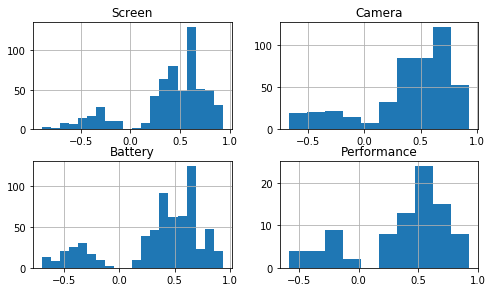

In [14]:
# Select a brand
BRAND = 'huawei'

## Get only the rows for the selected brand
sel_brand = phrasesDF[phrasesDF['brand'] == BRAND]
# Remove the neutral sentiment phrases, which tend to obscure the charts in our study
sel_brand = sel_brand.query('vader_sentiment < -0.1 or vader_sentiment > 0.1')  

# Create sentiment dataframes for each of the relevant aspects
sel_brand_battery = sel_brand[sel_brand['aspect'] == 'battery']['vader_sentiment']
sel_brand_screen = sel_brand[sel_brand['aspect'] == 'screen']['vader_sentiment']
sel_brand_camera = sel_brand[sel_brand['aspect'] == 'camera']['vader_sentiment']
sel_brand_performance = sel_brand[sel_brand['aspect'] == 'performance']['vader_sentiment']

# Chart a histogram for each of the aspects
import matplotlib
%matplotlib inline  
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,4))
plt.tight_layout()

axes[0,0].set_title("Screen")
axes[0,1].set_title("Camera")
axes[1,0].set_title("Battery")
axes[1,1].set_title("Performance")

sel_brand_screen.hist(ax=axes[0,0], bins=20)
sel_brand_camera.hist(ax=axes[0,1])
sel_brand_battery.hist(ax=axes[1,0], bins=20)
sel_brand_performance.hist(ax=axes[1,1])

### Usecase B:  Sort brands by aspect ratings

### What brands are best at a selected aspect? 

In [15]:
## Find which brands have most of the reviews, and drop the ones with fewer reviews
topBrandsDF = phrasesDF.groupby(['brand']).count()
topBrandsDF = topBrandsDF['phrase'].sort_values(ascending = False)[1:20]
topBrands = topBrandsDF.index.values
topBrandsDF

brand
samsung           19906
nokia              9773
lg                 9518
apple              9263
motorola           6926
sony               6652
htc                5491
posh mobile        5104
blackberry         3884
huawei             2905
cnpgd              2466
zte                1880
lg electronics     1776
alcatel            1718
asus               1492
otterbox           1028
polaroid            797
asus computers      673
verykool            611
Name: phrase, dtype: int64

In [16]:
# Make a dataframe with only the most reviewed brands 
mostBrandsReviews = phrasesDF[phrasesDF['brand'].isin(topBrands)] 
# Group by brand and aspect
s1 = mostBrandsReviews.groupby(['brand', 'aspect'])['vader_sentiment'].mean()
mostBrandsReviews = pd.DataFrame(s1, columns=['vader_sentiment'])

# Make a flat version of this DF
mostBrandsReviewsFlat = mostBrandsReviews.stack().reset_index()
mostBrandsReviewsFlat.columns.values
mostBrandsReviewsFlat['meanReview'] = mostBrandsReviewsFlat[0]
mostBrandsReviewsFlat = mostBrandsReviewsFlat.drop(['level_2', 0], axis=1)

mostBrandsReviews.head(15)

vader_sentiment
brand          aspect                      
alcatel        battery             0.178268
               camera              0.211906
               performance         0.216578
               screen              0.190165
apple          battery            -0.037958
               camera              0.160082
               performance         0.403919
               screen              0.023324
asus           battery             0.110413
               camera              0.211596
               performance         0.278378
               screen              0.159329
asus computers battery             0.090584
               camera              0.274595
               performance         0.360814

#### Brands with top battery sentiment ratings

In [17]:
aspect = 'battery'
mostBrandsReviewsFlat[mostBrandsReviewsFlat['aspect'] == aspect].sort_values(by=['meanReview'], ascending = False)[0:3]

,brand,aspect,meanReview
28,huawei,battery,0.216604
0,alcatel,battery,0.178268
72,zte,battery,0.144789


#### Brands with top screen sentiment ratings

In [18]:
aspect = 'screen'
mostBrandsReviewsFlat[mostBrandsReviewsFlat['aspect'] == aspect].sort_values(by=['meanReview'], ascending = False)[0:3]

,brand,aspect,meanReview
75,zte,screen,0.288299
31,huawei,screen,0.223562
15,asus computers,screen,0.202972


###  Brands with worst reviews in relevant aspects

#### Brands with worst battery sentiment ratings

In [19]:
aspect = 'battery'
mostBrandsReviewsFlat[mostBrandsReviewsFlat['aspect'] == aspect].sort_values(by=['meanReview'], ascending = True)[0:3]

,brand,aspect,meanReview
52,polaroid,battery,-0.128303
48,otterbox,battery,-0.050218
4,apple,battery,-0.037958


#### Brands with worst screen sentiment ratings

In [21]:
aspect = 'screen'
mostBrandsReviewsFlat[mostBrandsReviewsFlat['aspect'] == aspect].sort_values(by=['meanReview'], ascending = True)[0:3]

,brand,aspect,meanReview
23,cnpgd,screen,0.019074
7,apple,screen,0.023324
51,otterbox,screen,0.054884


### Usecase C:  Discovery of insightful reviews

In this section we are going to find reviews that have a low rating but high aspect sentiment scores.  The discrepancy between the rating and the sentiment should flag these reviews because most of these customers were on the fence, so the issues could be addressed and resolved by customer care.  

In [ ]:
s1 = phrasesDF.groupby(['review_id'])['vader_sentiment_pos'].mean()
resultsDF = pd.DataFrame(s1, columns=['vader_sentiment_pos'])
resultsDF['avg_vader_sentiment_pos'] = phrasesDF.groupby(['review_id'])['vader_sentiment_pos'].mean()
resultsDF['rating'] = phrasesDF.groupby(['review_id'])['rating'].mean()
resultsDF = resultsDF.query('rating == 1 and avg_vader_sentiment_pos > .8')
phrasesDF[ phrasesDF['review_id'].isin(resultsDF.index)]

#### The screen is great but...

In [ ]:
reviews[141974]

#### The camera is great but...

In [ ]:
reviews[223645]